In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sns.set(context='notebook', 
sns.set(context='paper', 
        # font_scale=8/8.8,
        style='ticks',
        color_codes=True, 
        rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'
# plt.rc('axes', labelsize=11)
# plt.rc('legend', fontsize=11)


%matplotlib inline

In [3]:
os.chdir("../")
os.getcwd()

'/lustre/eaglefs/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-pruning-outliers'

In [11]:
# load all the data
df_all = pd.DataFrame()
base_dir = "20220706_icsd_and_battery_learning_curve"
for run_id in range(1, 6):
    run_dir = f"{base_dir}/run_{run_id}"
    for i in range(10):
        pred_energies_file = f"{run_dir}/n_{i}/predicted_energies.csv.gz"
        if not os.path.isfile(pred_energies_file):
            print(pred_energies_file)
            continue
        df = pd.read_csv(pred_energies_file, index_col=0)
        df = df[df.set == 'test']
        df['run_id'] = run_id
        df['train_idx'] = i
        df_all = pd.concat([df_all, df])

print(len(df_all))
df_all.head(2)

20220706_icsd_and_battery_learning_curve/run_1/n_9/predicted_energies.csv.gz
20220706_icsd_and_battery_learning_curve/run_2/n_6/predicted_energies.csv.gz
20220706_icsd_and_battery_learning_curve/run_2/n_7/predicted_energies.csv.gz
20220706_icsd_and_battery_learning_curve/run_4/n_3/predicted_energies.csv.gz
20220706_icsd_and_battery_learning_curve/run_5/n_6/predicted_energies.csv.gz
67500


,id,type,composition,num_sites,hit_upper_bound,energyperatom,volperatom,scaled_input_volperatom,set,energy_predicted,run_id,train_idx
98,icsd_049751,icsd,Ba2Si1Te4,14,False,-4.180950,37.129097,2.394699,test,-4.527718,1,0
146,icsd_044369,icsd,Mn4N1,5,False,-7.502654,11.574158,1.600000,test,-4.267200,1,0


In [12]:
# get the MAE per set
df_all['energy_err'] = (df_all['energyperatom'] - df_all['energy_predicted']).abs()
df_all.head(2)
# df_mae = df_all.groupby(

,id,type,composition,num_sites,hit_upper_bound,energyperatom,volperatom,scaled_input_volperatom,set,energy_predicted,run_id,train_idx,energy_err
98,icsd_049751,icsd,Ba2Si1Te4,14,False,-4.180950,37.129097,2.394699,test,-4.527718,1,0,0.346768
146,icsd_044369,icsd,Mn4N1,5,False,-7.502654,11.574158,1.600000,test,-4.267200,1,0,3.235454


In [13]:
df2 = df_all[['type', 'train_idx', 'energy_err']].reset_index()
len(df2)

67500

In [14]:
num_train_list = np.logspace(2, np.log10(141385), num=10)
df2['num_train'] = df2.train_idx.apply(lambda x: num_train_list[x])
df2.head(2)

,index,type,train_idx,energy_err,num_train
0,98,icsd,0,0.346768,100.0
1,146,icsd,0,3.235454,100.0


In [15]:
df2['train_idx'].value_counts()

0    7500
1    7500
2    7500
4    7500
5    7500
8    7500
3    6000
7    6000
9    6000
6    4500
Name: train_idx, dtype: int64

20220706_icsd_and_battery_learning_curve/learning_curve.svg


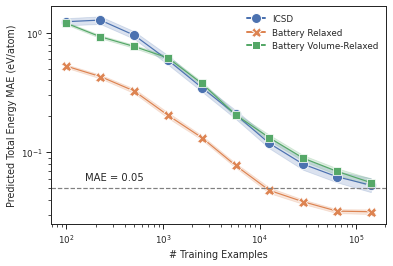

In [21]:
# plot the mean and error bars from the different run_ids 
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(
    data=df2, x='num_train', y='energy_err', 
    hue='type', style='type', markers=True, dashes=False,
    markersize=10,
)
ax.legend_.set_title(None)
# replace labels
new_labels = ['ICSD', 'Battery Relaxed', 'Battery Volume-Relaxed']
for t, l in zip(ax.legend_.texts, new_labels):
    t.set_text(l)
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)
    # lh._sizes = [30]
    lh.set_markersize(10)
    lh.set_markeredgecolor('white')
    lh.set_linewidth(2)

plt.axhline(0.05, color='gray', linestyle='--')
ax.text(.1, .2, 'MAE = 0.05',
        # color='black',
       transform=ax.transAxes)

plt.yscale('log')
plt.xscale('log')
plt.ylabel("Predicted Total Energy MAE (eV/atom)")
plt.xlabel("# Training Examples")
out_file = f"{base_dir}/learning_curve.svg"
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg', '.png'), 
            dpi=300,
            bbox_inches='tight')

In [20]:
df2.groupby(['train_idx', 'type']).energy_err.mean()

train_idx  type 
0          icsd     1.244409
           relax    0.526958
           vol      1.205342
1          icsd     1.283514
           relax    0.431905
           vol      0.930252
2          icsd     0.959113
           relax    0.326803
           vol      0.771708
3          icsd     0.592976
           relax    0.204592
           vol      0.618683
4          icsd     0.349030
           relax    0.132944
           vol      0.378634
5          icsd     0.207809
           relax    0.077666
           vol      0.206677
6          icsd     0.118816
           relax    0.047990
           vol      0.132421
7          icsd     0.079546
           relax    0.038522
           vol      0.089412
8          icsd     0.062412
           relax    0.032161
           vol      0.069277
9          icsd     0.053001
           relax    0.031795
           vol      0.055764
Name: energy_err, dtype: float64